In [ ]:
!pip install datasets

In [ ]:
# Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from datasets import load_dataset, Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
from datasets import ClassLabel

C:\Users\Lu Huang\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Lu Huang\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [ ]:
# Load dataset (with MelSpectrogram + MFCC features)
raw_ds = load_dataset("ZZZtong/common-accent-MelSpec-MFCC", split="train")
accents = raw_ds.unique("accent")

# optimize 1: Label Encoding

In [ ]:
# Method A: Using LabelEncoder + datasets.map() (Optimized)
start_a = time.time()
le = LabelEncoder()
le.fit(accents)
ds_map = raw_ds.map(lambda ex: {"label": le.transform([ex["accent"]])[0]})
time_a = time.time() - start_a
print(f" datasets.map + LabelEncoder: {time_a:.2f} seconds")

 datasets.map + LabelEncoder: 0.41 seconds


In [ ]:
# Method B: Manual loop to encode labels and rebuild dataset (Unoptimized)

start_b = time.time()
label_dict = {accent: i for i, accent in enumerate(accents)}
examples = []
for ex in raw_ds:
    ex = dict(ex)
    ex["label"] = label_dict[ex["accent"]]
    examples.append(ex)
ds_manual = Dataset.from_list(examples)
time_b = time.time() - start_b
print(f"[Unoptimized] Manual loop + Dataset rebuild: {time_b:.2f} seconds")

[Unoptimized] Manual loop + Dataset rebuild: 184.67 seconds


In [ ]:
# Speedup ratio
print(f"Speedup: {time_b / time_a:.2f}x faster using map + LabelEncoder")


Speedup: 450.49x faster using map + LabelEncoder


In [ ]:
# Set the optimized dataset as the working dataset
ds=ds_map

# optimize 2: Train/Validation Split

In [ ]:
# Method A: Unoptimized - Convert to pandas and split using sklearn
start_a = time.time()
df_full = ds.to_pandas()
train_df, val_df = train_test_split(
    df_full,
    test_size=0.2,
    stratify=df_full["label"],
    random_state=42
)
dataset_pandas = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "validation": Dataset.from_pandas(val_df)
})
time_a = time.time() - start_a
print(f"[Unoptimized] pandas + sklearn split: {time_a:.2f} seconds")


[Unoptimized] pandas + sklearn split: 8.99 seconds


In [ ]:
# Method B: Optimized - Using datasets.train_test_split with ClassLabel


class_label = ClassLabel(names=accents)
ds = ds.cast_column("label", class_label)

start_opt = time.time()
dataset_fast = ds.train_test_split(test_size=0.2, stratify_by_column="label", seed=42)
dataset_fast = DatasetDict({
    "train": dataset_fast["train"],
    "val": dataset_fast["test"]
})
time_opt = time.time() - start_opt
print(f" datasets.train_test_split: {time_opt:.2f}s")

# Speedup comparison
print(f"Speedup: {time_a / time_opt:.2f}x faster using datasets' built-in split")



Casting the dataset:   0%|          | 0/2538 [00:00<?, ? examples/s]

 datasets.train_test_split: 0.08s
Speedup: 117.87x faster using datasets' built-in split


In [ ]:
# Use the optimized split for training
dataset = dataset_fast


In [ ]:
# Define a custom collate function to batch variable-size inputs
def collate_fn(batch):
    X = [torch.tensor(ex["mel_spec"]).unsqueeze(0).float() for ex in batch]
    y = [ex["label"] for ex in batch]
    return torch.stack(X), torch.tensor(y)

In [ ]:
# Wrap datasets with DataLoaders
train_loader = DataLoader(dataset["train"], batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(dataset["val"], batch_size=32, shuffle=False, collate_fn=collate_fn)

# optimize 3：model architectural （using adaptive: similar time but less loss)

In [ ]:
class CNN_Flatten(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # [32, 32, 250]
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # [64, 16, 125]
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        with torch.no_grad():
            dummy_input = torch.rand(1, 1, 64, 501)
            dummy_output = self.features(dummy_input)
            flatten_dim = dummy_output.view(1, -1).shape[1]

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(flatten_dim, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


In [ ]:
# CNN with AdaptiveAvgPool
class CNN_Adaptive(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Benchmark training time for one epoch (30 batches) and average over 3 runs
def benchmark_model_avg(model_class, name, num_classes, loader, repeats=3):
    times = []
    for _ in range(repeats):
        model = model_class(num_classes).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

        model.train()
        start = time.time()
        total_loss = 0
        for i, (X, y) in enumerate(loader):
            # Only run 30 batches to simulate a fast training loop
            if i >= 30:
                break
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            preds = model(X)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        times.append(time.time() - start)

    mean_time = sum(times) / len(times)
    num_params = sum(p.numel() for p in model.parameters())
    print(f"{name:<20} | Avg Time: {mean_time:.2f}s | Params: {num_params/1e6:.2f}M | Avg Loss: {total_loss/30:.4f}")
    return mean_time

time1 = benchmark_model_avg(CNN_Flatten, "Flatten", len(le.classes_), train_loader)
time2 = benchmark_model_avg(CNN_Adaptive, "AdaptivePool", len(le.classes_), train_loader)
print(f"\nSpeedup: {time1 / time2:.2f}x faster using AdaptiveAvgPool")



Flatten              | Avg Time: 61.53s | Params: 1.63M | Avg Loss: 33.0690
AdaptivePool         | Avg Time: 61.46s | Params: 0.09M | Avg Loss: 1.7424

Speedup: 1.00x faster using AdaptiveAvgPool


Given similar training time, but the AdaptivePool model has significantly fewer parameters and a lower loss, it suggests better computational efficiency and potentially stronger generalization. Therefore, AdaptivePool is preferred because it offers a better balance between performance and resource usage.

In [ ]:
# Instantiate model, optimizer, loss function, and scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(le.classes_)
model = CNN_Adaptive(num_classes).to(device)


In [ ]:
# Compute class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# Cross-entropy loss with class weights
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

# Adam optimizer with learning rate decay
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Reduce learning rate when validation accuracy plateaus
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# optimize 4: evaluation function

In [ ]:
#  Unoptimized version: does not use torch.no_grad(), and calls item() unnecessarily
def evaluate_unoptimized(model, loader):
    model.eval()
    total = 0
    correct = 0
    for X, y in loader:
        X = X.to(device)
        y = y.to(device)
        preds = model(X)

        # Calling .item() repeatedly on GPU tensors is slow (especially for small batches)
        predicted = preds.argmax(dim=1)
        correct += ((predicted == y).sum().item())  # Converts to scalar every iteration
        total += y.size(0)

    return correct / total


In [ ]:
# Evaluation function to compute validation accuracy
def evaluate(model, loader):
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            preds = model(X)
            predicted = preds.argmax(dim=1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    return correct / total

In [ ]:
start = time.time()
acc_unopt = evaluate_unoptimized(model, val_loader)
t_unopt = time.time() - start

start = time.time()
acc_opt = evaluate(model, val_loader)
t_opt = time.time() - start

print(f" Unoptimized Eval: Acc = {acc_unopt:.2%}, Time = {t_unopt:.2f}s")
print(f" Optimized Eval  : Acc = {acc_opt:.2%}, Time = {t_opt:.2f}s")
print(f" Speedup: {t_unopt / t_opt:.2f}x")


 Unoptimized Eval: Acc = 10.83%, Time = 23.74s
 Optimized Eval  : Acc = 10.83%, Time = 20.91s
 Speedup: 1.14x


# training loop

In [ ]:
# training for 1 epoch
def train_one_epoch(model, optimizer, criterion, loader):
    model.train()
    total_loss = 0.0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        preds = model(X)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

import torch._dynamo as dynamo

def benchmark_compile(model_class, label, use_compile=False):
    model = model_class(num_classes).to(device)

    if use_compile:
        dynamo.config.suppress_errors = True
        model = torch.compile(model, backend="eager")

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    start = time.time()
    loss = train_one_epoch(model, optimizer, criterion, train_loader)
    val_acc = evaluate(model, val_loader)
    duration = time.time() - start

    print(f"{label:<24} | Time: {duration:.2f}s | Loss: {loss:.4f} | Val Acc: {val_acc:.2%}")
    return duration



In [ ]:
print(" Benchmarking torch.compile() using fallback backend (eager)...\n")

t1 = benchmark_compile(CNN_Adaptive, " Normal Model", use_compile=False)
t2 = benchmark_compile(CNN_Adaptive, " Compiled (eager)", use_compile=True)

print(f"\n Speedup from torch.compile(eager): {t1 / t2:.2f}x")


 Benchmarking torch.compile() using fallback backend (eager)...

 Normal Model            | Time: 77.99s | Loss: 1.7004 | Val Acc: 25.20%
 Compiled (eager)        | Time: 74.47s | Loss: 1.6873 | Val Acc: 38.39%

 Speedup from torch.compile(eager): 1.05x


# optimize 4: gpu （1 epoch & no repeats comparison)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# Benchmark one epoch (30 batches) of training on either CPU or GPU
def benchmark_device(model_class, name, loader, use_gpu=True):
    # Select device based on flag and availability
    device = torch.device("cuda" if (torch.cuda.is_available() and use_gpu) else "cpu")

    # Initialize model, loss function, optimizer
    model = model_class(num_classes).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    model.train()
    start = time.time()
    total_loss = 0.0

    # Run 30 training batches
    for i, (X, y) in enumerate(loader):
        if i >= 30:
            break
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        preds = model(X)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    end = time.time()

    print(f"{name:<15} | Device: {device} | Time: {end - start:.2f}s | Avg Loss: {total_loss / 30:.4f}")


In [ ]:
# Run the benchmark on both CPU and GPU
benchmark_device(CNN_Adaptive, "CPU Run", train_loader, use_gpu=False)
benchmark_device(CNN_Adaptive, "GPU Run", train_loader, use_gpu=True)


CPU Run         | Device: cpu | Time: 100.21s | Avg Loss: 1.7420
GPU Run         | Device: cuda | Time: 33.63s | Avg Loss: 1.7546


# more stable comparison : 5 epoch & 3 repeated tests

In [ ]:
# Benchmark 5 epochs with 3 repeated runs on CPU vs GPU
def benchmark_device_avg(model_class, name, loader, use_gpu=True, epochs=5, repeats=3, max_batches=50):
    device = torch.device("cuda" if (torch.cuda.is_available() and use_gpu) else "cpu")
    durations = []

    for r in range(repeats):
        model = model_class(num_classes).to(device)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

        start = time.time()
        model.train()
        for epoch in range(epochs):
            # Use tqdm to show batch progress for each epoch
            for i, (X, y) in enumerate(tqdm(loader, desc=f"{name} | Epoch {epoch+1}", leave=False)):
                if i >= max_batches:
                    break
                X, y = X.to(device), y.to(device)
                optimizer.zero_grad()
                preds = model(X)
                loss = criterion(preds, y)
                loss.backward()
                optimizer.step()
        durations.append(time.time() - start)

    avg_time = sum(durations) / len(durations)
    print(f"{name:<15} | Device: {device} | Avg Time over {repeats} runs: {avg_time:.2f}s")
    return avg_time


In [ ]:
benchmark_device_avg(CNN_Adaptive, "Adaptive CNN", train_loader, use_gpu=True)
benchmark_device_avg(CNN_Adaptive, "Adaptive CNN", train_loader, use_gpu=False)


Adaptive CNN    | Device: cuda | Avg Time over 3 runs: 235.41s


Adaptive CNN    | Device: cpu | Avg Time over 3 runs: 797.23s


797.2290807565054

# more stable comparison : 10 epoch

In [ ]:
# Benchmark 15 epochs with a single run on CPU or GPU
def benchmark_device_avg(model_class, name, loader, use_gpu=True, epochs=10, repeats=1, max_batches=50):
    device = torch.device("cuda" if (torch.cuda.is_available() and use_gpu) else "cpu")
    durations = []

    for r in range(repeats):
        model = model_class(num_classes).to(device)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

        start = time.time()
        model.train()
        for epoch in range(epochs):
            for i, (X, y) in enumerate(tqdm(loader, desc=f"{name} | Epoch {epoch+1}", leave=False)):
                if i >= max_batches:
                    break
                X, y = X.to(device), y.to(device)
                optimizer.zero_grad()
                preds = model(X)
                loss = criterion(preds, y)
                loss.backward()
                optimizer.step()
        durations.append(time.time() - start)

    avg_time = sum(durations) / len(durations)
    print(f"{name:<15} | Device: {device} | Avg Time (10 epochs): {avg_time:.2f}s")
    return avg_time


In [ ]:
# Run benchmark on GPU
benchmark_device_avg(CNN_Adaptive, "Adaptive CNN", train_loader, use_gpu=True)

# Run benchmark on CPU
benchmark_device_avg(CNN_Adaptive, "Adaptive CNN", train_loader, use_gpu=False)


Adaptive CNN    | Device: cuda | Avg Time (10 epochs): 461.43s


Adaptive CNN | Epoch 10:  59%|█████▉    | 38/64 [02:01<01:20,  3.10s/it]

In [ ]:
# Run benchmark on CPU
benchmark_device_avg(CNN_Adaptive, "Adaptive CNN", train_loader, use_gpu=False)


Adaptive CNN    | Device: cpu | Avg Time (10 epochs): 1575.52s


1575.5164103507996

# Other attempts: gpu + torch compile (10 epoch comparison)

In [ ]:
import torch._dynamo

def benchmark_compile_single(model_class, name, loader, use_gpu=True, use_compile=True, epochs=10, max_batches=50):
    device = torch.device("cuda" if (torch.cuda.is_available() and use_gpu) else "cpu")
    model = model_class(num_classes).to(device)

    if use_compile:
        torch._dynamo.config.suppress_errors = True
        model = torch.compile(model, backend="eager")  # Fallback backend that works on Colab

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    model.train()
    start = time.time()
    for epoch in range(epochs):
        for i, (X, y) in enumerate(tqdm(loader, desc=f"{name} | Epoch {epoch+1}", leave=False)):
            if i >= max_batches:
                break
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            preds = model(X)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()
    duration = time.time() - start

    print(f"{name:<20} | Device: {device} | Time for {epochs} epochs: {duration:.2f}s")
    return duration


In [ ]:
# Baseline (no compile)
benchmark_compile_single(CNN_Adaptive, "Baseline CNN", train_loader, use_compile=False)

# torch.compile version
benchmark_compile_single(CNN_Adaptive, "Compiled CNN", train_loader, use_compile=True)


Baseline CNN         | Device: cuda | Time for 10 epochs: 521.02s


Compiled CNN         | Device: cuda | Time for 10 epochs: 512.66s


512.6571445465088


Although `torch.compile()` is designed to accelerate model training by optimizing execution graphs, in this case the speedup is minimal. This is because:

1. **Fallback backend (`eager`)**: Since Colab does not provide a C++ compiler, `torch.compile()` uses the fallback `"eager"` backend instead of the faster `"inductor"` backend, which limits its acceleration capabilities.

2. **Small model**: The CNN model used (`CNN_Adaptive`) is relatively lightweight (~0.09M parameters), so GPU compute is not the main bottleneck. As a result, the overhead of compiling the model doesn't yield noticeable improvements.

3. **Short training duration**: Running only 10 epochs on 50 batches does not provide enough workload for the compiler to amortize its optimization overhead. `torch.compile()` is generally more effective in longer or large-scale training.

Therefore, while `torch.compile()` works correctly, its benefits are not evident in this specific setup.


# Training for 50 epoch using gpu

In [ ]:
# Setup model, optimizer, loss, and scheduler
model = CNN_Adaptive(num_classes).to(device)

class_weights = compute_class_weight('balanced', classes=np.unique(train_df['label']), y=train_df['label'])
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# Train for 50 epochs and save the best model （72 minutes used for training)
best_val_acc = 0.0
for epoch in range(50):
    model.train()
    total_loss = 0.0
    for X, y in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        preds = model(X)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    val_acc = evaluate(model, val_loader)
    scheduler.step(val_acc)
    print(f"Epoch {epoch+1}, Train Loss: {total_loss:.4f}, Val Acc: {val_acc * 100:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_improved_model.pt")
        print(" Best model saved.")


Epoch 1, Train Loss: 113.5060, Val Acc: 35.43%
 Best model saved.


Epoch 2, Train Loss: 110.1049, Val Acc: 23.43%


Epoch 3, Train Loss: 106.2252, Val Acc: 35.04%


Epoch 4, Train Loss: 101.9284, Val Acc: 39.76%
 Best model saved.


Epoch 5, Train Loss: 98.2796, Val Acc: 34.45%


Epoch 6, Train Loss: 95.5715, Val Acc: 37.99%


Epoch 7, Train Loss: 93.9894, Val Acc: 41.93%
 Best model saved.


Epoch 8, Train Loss: 91.9179, Val Acc: 49.41%
 Best model saved.


Epoch 9, Train Loss: 90.6625, Val Acc: 48.62%


Epoch 10, Train Loss: 89.5781, Val Acc: 44.49%


Epoch 11, Train Loss: 88.4909, Val Acc: 45.67%


Epoch 12, Train Loss: 86.4758, Val Acc: 33.86%


Epoch 13, Train Loss: 84.3414, Val Acc: 52.95%
 Best model saved.


Epoch 14, Train Loss: 83.5631, Val Acc: 47.64%


Epoch 15, Train Loss: 84.8094, Val Acc: 55.51%
 Best model saved.


Epoch 16, Train Loss: 84.9291, Val Acc: 43.31%


Epoch 17, Train Loss: 84.7134, Val Acc: 44.29%


Epoch 18, Train Loss: 82.6587, Val Acc: 43.90%


Epoch 19, Train Loss: 81.2441, Val Acc: 54.33%


Epoch 20, Train Loss: 80.3848, Val Acc: 50.39%


Epoch 21, Train Loss: 79.8744, Val Acc: 52.36%


Epoch 22, Train Loss: 80.1502, Val Acc: 50.20%


Epoch 23, Train Loss: 79.1833, Val Acc: 55.31%


Epoch 24, Train Loss: 79.4367, Val Acc: 55.91%
 Best model saved.


Epoch 25, Train Loss: 78.4252, Val Acc: 54.13%


Epoch 26, Train Loss: 78.3133, Val Acc: 58.07%
 Best model saved.


Epoch 27, Train Loss: 78.2381, Val Acc: 56.50%


Epoch 28, Train Loss: 79.0184, Val Acc: 56.89%


Epoch 29, Train Loss: 77.6958, Val Acc: 56.10%


Epoch 30, Train Loss: 76.7468, Val Acc: 57.48%


Epoch 31, Train Loss: 78.3494, Val Acc: 58.46%
 Best model saved.


Epoch 32, Train Loss: 77.3715, Val Acc: 57.87%


Epoch 33, Train Loss: 77.8486, Val Acc: 56.50%


Epoch 34, Train Loss: 76.6919, Val Acc: 57.28%


Epoch 35, Train Loss: 77.2062, Val Acc: 58.46%


Epoch 36, Train Loss: 75.9531, Val Acc: 57.87%


Epoch 37, Train Loss: 77.3540, Val Acc: 57.87%


Epoch 38, Train Loss: 76.2342, Val Acc: 57.28%


Epoch 39, Train Loss: 75.2163, Val Acc: 57.28%


Epoch 40, Train Loss: 75.9691, Val Acc: 58.46%


Epoch 41, Train Loss: 76.1887, Val Acc: 58.07%


Epoch 42, Train Loss: 75.9005, Val Acc: 57.87%


Epoch 43, Train Loss: 75.8296, Val Acc: 58.27%


Epoch 44, Train Loss: 76.5450, Val Acc: 58.07%


Epoch 45, Train Loss: 76.3633, Val Acc: 57.87%


Epoch 46, Train Loss: 75.5332, Val Acc: 58.27%


Epoch 47, Train Loss: 74.9102, Val Acc: 58.07%


Epoch 48, Train Loss: 75.8681, Val Acc: 58.07%


Epoch 49, Train Loss: 76.1181, Val Acc: 58.27%


Epoch 50, Train Loss: 75.2787, Val Acc: 58.46%


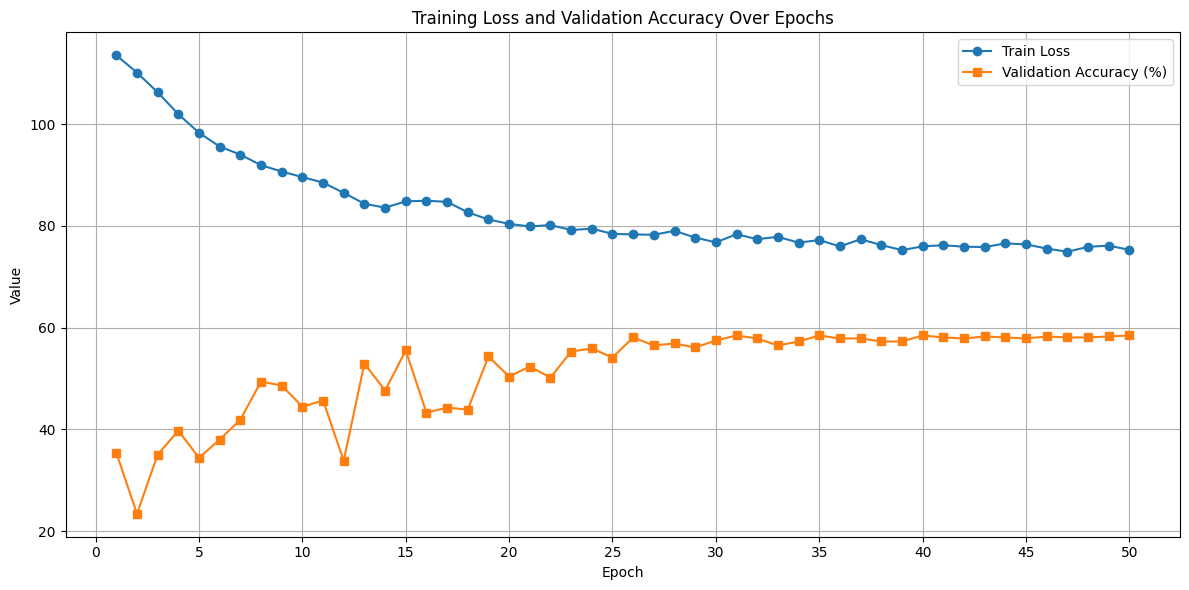

In [ ]:
# Re-run after kernel reset
import matplotlib.pyplot as plt

# Re-initialize data
epochs = list(range(1, 51))
train_loss = [
    113.5060, 110.1049, 106.2252, 101.9284, 98.2796, 95.5715, 93.9894, 91.9179, 90.6625, 89.5781,
    88.4909, 86.4758, 84.3414, 83.5631, 84.8094, 84.9291, 84.7134, 82.6587, 81.2441, 80.3848,
    79.8744, 80.1502, 79.1833, 79.4367, 78.4252, 78.3133, 78.2381, 79.0184, 77.6958, 76.7468,
    78.3494, 77.3715, 77.8486, 76.6919, 77.2062, 75.9531, 77.3540, 76.2342, 75.2163, 75.9691,
    76.1887, 75.9005, 75.8296, 76.5450, 76.3633, 75.5332, 74.9102, 75.8681, 76.1181, 75.2787
]
val_acc = [
    35.43, 23.43, 35.04, 39.76, 34.45, 37.99, 41.93, 49.41, 48.62, 44.49,
    45.67, 33.86, 52.95, 47.64, 55.51, 43.31, 44.29, 43.90, 54.33, 50.39,
    52.36, 50.20, 55.31, 55.91, 54.13, 58.07, 56.50, 56.89, 56.10, 57.48,
    58.46, 57.87, 56.50, 57.28, 58.46, 57.87, 57.87, 57.28, 57.28, 58.46,
    58.07, 57.87, 58.27, 58.07, 57.87, 58.27, 58.07, 58.07, 58.27, 58.46
]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label="Train Loss", color='tab:blue', marker='o')
plt.plot(epochs, val_acc, label="Validation Accuracy (%)", color='tab:orange', marker='s')
plt.title("Training Loss and Validation Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.xticks(range(0, 51, 5))
plt.tight_layout()
plt.show()


In [ ]:
# Load test set and process labels
test_ds = load_dataset("ZZZtong/common-accent-MelSpec-MFCC", split="test")
test_ds = test_ds.map(lambda ex: {"label": le.transform([ex["accent"]])[0]})
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Load and evaluate the saved best model
model = CNN_Adaptive(num_classes).to(device)
model.load_state_dict(torch.load("best_improved_model.pt"))
model.eval()

test_acc = evaluate(model, test_loader)
print(f"Final Test Accuracy: {test_acc * 100:.2f}%")

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Final Test Accuracy: 55.99%


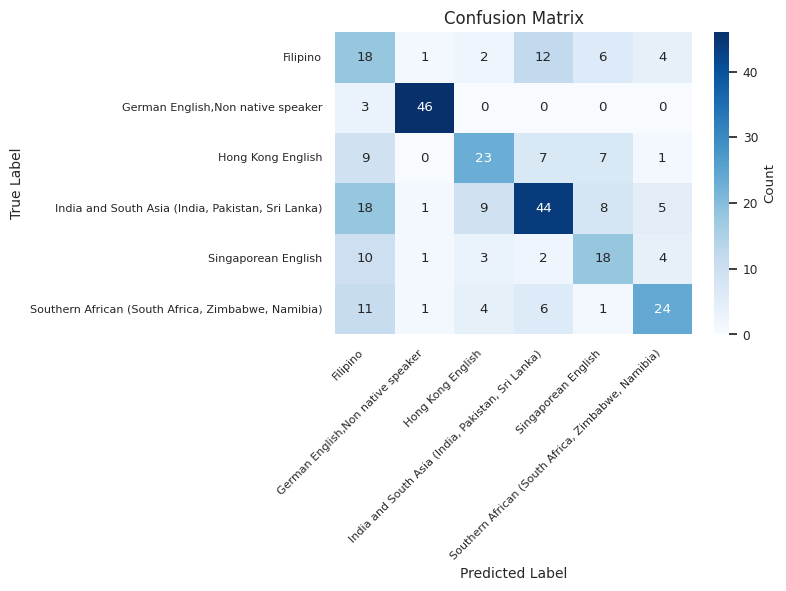

In [ ]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_true = []
y_pred = []

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        preds = model(X)
        predicted = preds.argmax(dim=1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
labels = le.classes_


plt.figure(figsize=(8, 6))  # Shrink the overall figure
sns.set(font_scale=0.8)     # Shrink font size for labels and numbers

ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                 xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Count'})

plt.xlabel("Predicted Label", fontsize=10)
plt.ylabel("True Label", fontsize=10)
plt.title("Confusion Matrix", fontsize=12)
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
ax.set_yticklabels(labels, rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

In [ ]:
# Print classification report
report = classification_report(y_true, y_pred, target_names=labels, digits=4)
print("Classification Report:\n", report)

Classification Report:
                                                     precision    recall  f1-score   support

                                          Filipino     0.2609    0.4186    0.3214        43
                 German English,Non native speaker     0.9200    0.9388    0.9293        49
                                 Hong Kong English     0.5610    0.4894    0.5227        47
 India and South Asia (India, Pakistan, Sri Lanka)     0.6197    0.5176    0.5641        85
                               Singaporean English     0.4500    0.4737    0.4615        38
Southern African (South Africa, Zimbabwe, Namibia)     0.6316    0.5106    0.5647        47

                                          accuracy                         0.5599       309
                                         macro avg     0.5739    0.5581    0.5606       309
                                      weighted avg     0.5894    0.5599    0.5694       309

